# VQ-VAE Reconstruction Visualization

This notebook loads a trained VQ-VAE model from a checkpoint and visualizes original images alongside their reconstructions.

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import os
import json
from dataclasses import dataclass
import typing
from abc import ABC, abstractmethod

# Import your VQ-VAE classes (assuming they're in the same directory)
# If not, adjust the import path
from vq_vae import VQVAEConfig, VQVAE, BaseVAE, Encoder, Decoder, VectorQuantizer

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [9]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

print(f"Test dataset size: {len(test_dataset)}")

Test dataset size: 10000


In [13]:
def load_config_from_json(config_path: str) -> VQVAEConfig:
    """Load VQVAEConfig from JSON file"""
    with open(config_path, 'r') as f:
        config_dict = json.load(f)
    
    # Convert list back to tuple for hidden_dims if needed
    if 'hidden_dims' in config_dict:
        config_dict['hidden_dims'] = tuple(config_dict['hidden_dims'])
    
    # Remove non-config fields if present
    config_dict.pop('best_seed', None)
    
    return VQVAEConfig(**config_dict)

def load_config_from_checkpoint(checkpoint_path: str, device: str = 'cpu') -> VQVAEConfig:
    """Load VQVAEConfig from checkpoint file"""
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    if 'config' in checkpoint and checkpoint['config'] is not None:
        return checkpoint['config']
    else:
        raise ValueError("No config found in checkpoint file")

def load_best_model(checkpoint_dir: str = './final_model_checkpoints', 
                   device: str = None) -> tuple[VQVAE, VQVAEConfig]:
    """Load the best model with its configuration"""
    
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Try to load config from JSON first (more reliable)
    json_config_path = os.path.join(checkpoint_dir, 'best_config.json')
    checkpoint_path = os.path.join(checkpoint_dir, 'best_model.pth')
    
    if os.path.exists(json_config_path):
        config = load_config_from_json(json_config_path)
    elif os.path.exists(checkpoint_path):
        config = load_config_from_checkpoint(checkpoint_path, device)
    else:
        raise FileNotFoundError("Neither config.json nor checkpoint file found")
    
    # Initialize model
    model = VQVAE(config)
    
    # Load weights if checkpoint exists
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Model weights loaded from {checkpoint_path}")
    
    model.to(device)
    model.eval()  # Set to evaluation mode
    
    return model, config

# Usage
model, config = load_best_model('/home/nair-group/abian_torres/repositories/tool_generation/final_model_checkpoints')
print(f"Loaded model with embedding_dim: {config.embedding_dim}")

Model weights loaded from /home/nair-group/abian_torres/repositories/tool_generation/final_model_checkpoints/best_model.pth
Loaded model with embedding_dim: 64


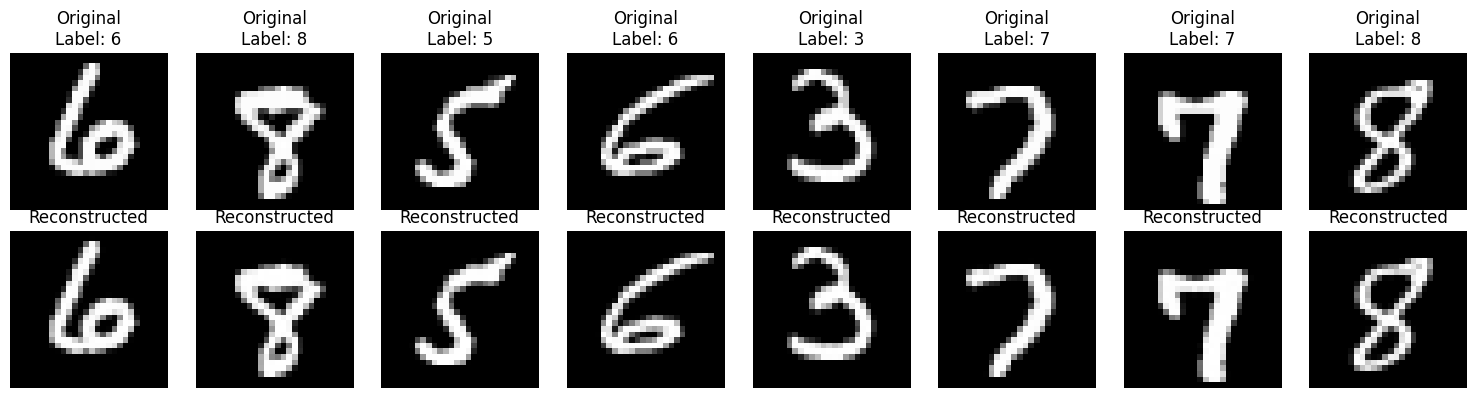

In [17]:
# Function to visualize original vs reconstructed images
def visualize_reconstructions(model, data_loader, num_samples=8):
    """Visualize original images and their reconstructions"""
    model.eval()
    
    # Get a batch of test images
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(data_loader):
            data = data.to(device)
            
            # Get reconstructions
            reconstructions, _ = model(data)
            
            # Convert to numpy for visualization
            original = data[:num_samples].cpu().numpy()
            recon = reconstructions[:num_samples].cpu().numpy()
            labels = targets[:num_samples].numpy()
            
            break  # Only need one batch
    
    # Create visualization
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 4))
    
    for i in range(num_samples):
        # Original images
        axes[0, i].imshow(original[i].squeeze(), cmap='gray')
        axes[0, i].set_title(f'Original\nLabel: {labels[i]}')
        axes[0, i].axis('off')
        
        # Reconstructed images
        axes[1, i].imshow(recon[i].squeeze(), cmap='gray')
        axes[1, i].set_title('Reconstructed')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return original, recon

# Visualize reconstructions
if 'model' in locals():
    original_images, reconstructed_images = visualize_reconstructions(model, test_loader)
else:
    print("Model not loaded. Please check the checkpoint path.")

In [18]:
# Calculate and visualize reconstruction metrics
def calculate_reconstruction_metrics(model, data_loader, num_batches=10):
    """Calculate reconstruction loss and other metrics"""
    model.eval()
    total_recon_loss = 0
    total_vq_loss = 0
    total_samples = 0
    
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(data_loader):
            if batch_idx >= num_batches:
                break
                
            data = data.to(device)
            recon, vq_loss = model(data)
            
            # Calculate reconstruction loss
            recon_loss = F.mse_loss(recon, data, reduction='sum')
            
            total_recon_loss += recon_loss.item()
            total_vq_loss += vq_loss.item() * data.size(0)
            total_samples += data.size(0)
    
    avg_recon_loss = total_recon_loss / total_samples
    avg_vq_loss = total_vq_loss / total_samples
    
    print(f"Average Reconstruction Loss: {avg_recon_loss:.4f}")
    print(f"Average VQ Loss: {avg_vq_loss:.4f}")
    print(f"Total Loss: {avg_recon_loss + avg_vq_loss:.4f}")
    
    return avg_recon_loss, avg_vq_loss

# Calculate metrics
if 'model' in locals():
    recon_loss, vq_loss = calculate_reconstruction_metrics(model, test_loader)
else:
    print("Model not loaded. Please check the checkpoint path.")

Average Reconstruction Loss: 0.1831
Average VQ Loss: 0.0003
Total Loss: 0.1834


Codebook shape: (64, 2048)
Number of embeddings: 2048
Embedding dimension: 64


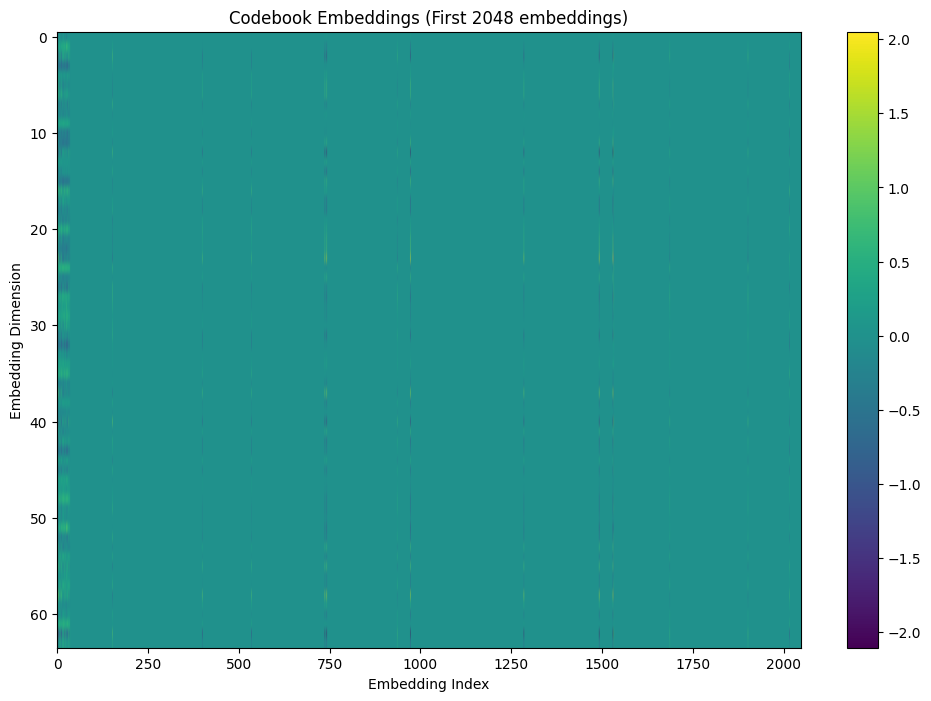

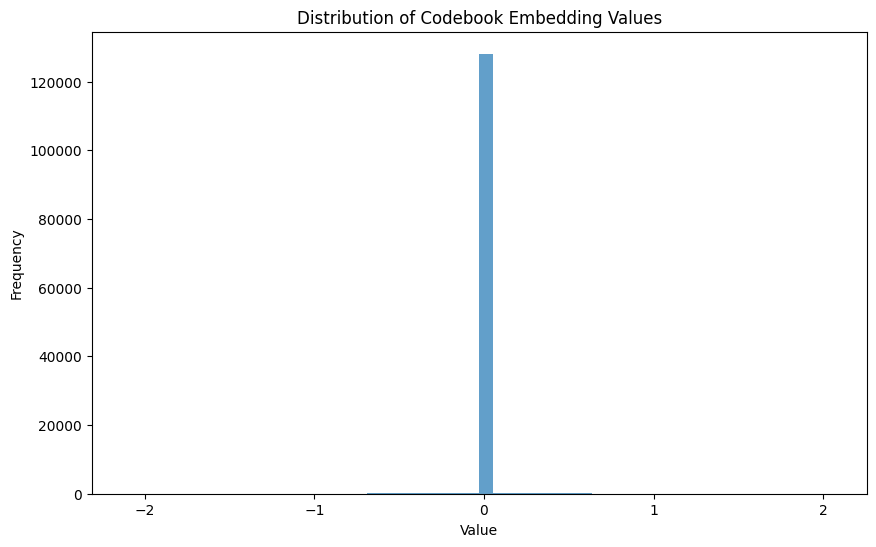

In [20]:
# Visualize the learned codebook embeddings
def visualize_codebook(model, num_embeddings_to_show=64):
    """Visualize the learned codebook embeddings"""
    # Get the codebook embeddings
    embeddings = model.vector_quantizer.embedding.detach().cpu().numpy()
    
    print(f"Codebook shape: {embeddings.shape}")
    print(f"Number of embeddings: {model.vector_quantizer.num_embeddings}")
    print(f"Embedding dimension: {model.vector_quantizer.embedding_dim}")
    
    # Visualize first few embeddings as heatmap
    num_to_show = min(num_embeddings_to_show, embeddings.shape[1])
    
    plt.figure(figsize=(12, 8))
    plt.imshow(embeddings[:, :num_to_show], cmap='viridis', aspect='auto')
    plt.colorbar()
    plt.title(f'Codebook Embeddings (First {num_to_show} embeddings)')
    plt.xlabel('Embedding Index')
    plt.ylabel('Embedding Dimension')
    plt.show()
    
    # Show distribution of embedding values
    plt.figure(figsize=(10, 6))
    plt.hist(embeddings.flatten(), bins=50, alpha=0.7)
    plt.title('Distribution of Codebook Embedding Values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

# Visualize codebook
if 'model' in locals():
    visualize_codebook(model, num_embeddings_to_show=2048)
else:
    print("Model not loaded. Please check the checkpoint path.")

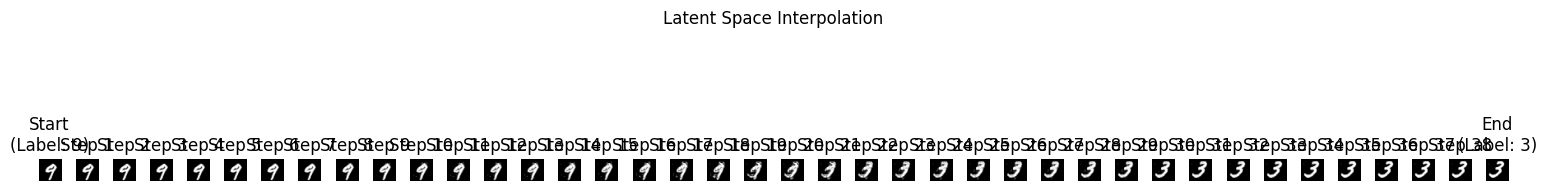

In [27]:
# Function to interpolate between two images in the latent space
def interpolate_reconstructions(model, data_loader, num_steps=40):
    """Interpolate between two images in the quantized latent space"""
    model.eval()
    
    with torch.no_grad():
        # Get two different images
        for data, targets in data_loader:
            data = data.to(device)
            if len(data) >= 2:
                img1, img2 = data[0:1], data[1:2]
                label1, label2 = targets[0].item(), targets[1].item()
                break
        
        # Encode both images
        z1 = model.encode(img1)
        z2 = model.encode(img2)
        
        # Create interpolation steps
        alphas = torch.linspace(0, 1, num_steps).to(device)
        
        interpolated_images = []
        
        for alpha in alphas:
            # Linear interpolation in latent space
            z_interp = (1 - alpha) * z1 + alpha * z2
            
            # Quantize the interpolated latent
            z_q, _ = model.vector_quantizer(z_interp)
            
            # Decode
            recon = model.decode(z_q)
            interpolated_images.append(recon.cpu().numpy())
    
    # Visualize interpolation
    fig, axes = plt.subplots(1, num_steps, figsize=(15, 3))
    
    for i, img in enumerate(interpolated_images):
        axes[i].imshow(img.squeeze(), cmap='gray')
        if i == 0:
            axes[i].set_title(f'Start\n(Label: {label1})')
        elif i == num_steps - 1:
            axes[i].set_title(f'End\n(Label: {label2})')
        else:
            axes[i].set_title(f'Step {i}')
        axes[i].axis('off')
    
    plt.suptitle('Latent Space Interpolation')
    plt.tight_layout()
    plt.show()

# Perform interpolation
if 'model' in locals():
    interpolate_reconstructions(model, test_loader)
else:
    print("Model not loaded. Please check the checkpoint path.")

In [23]:
# Save some reconstruction examples
def save_reconstruction_examples(model, data_loader, save_dir='./reconstruction_examples'):
    """Save some reconstruction examples to disk"""
    import os
    from PIL import Image
    
    os.makedirs(save_dir, exist_ok=True)
    
    model.eval()
    
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(data_loader):
            if batch_idx >= 5:  # Save only first 5 batches
                break
                
            data = data.to(device)
            reconstructions, _ = model(data)
            
            for i in range(min(4, len(data))):  # Save first 4 images from each batch
                # Original
                orig_img = (data[i].cpu().numpy().squeeze() * 255).astype(np.uint8)
                orig_pil = Image.fromarray(orig_img, mode='L')
                orig_pil.save(os.path.join(save_dir, f'batch_{batch_idx}_img_{i}_original_label_{targets[i].item()}.png'))
                
                # Reconstruction
                recon_img = (reconstructions[i].cpu().numpy().squeeze() * 255).astype(np.uint8)
                recon_pil = Image.fromarray(recon_img, mode='L')
                recon_pil.save(os.path.join(save_dir, f'batch_{batch_idx}_img_{i}_reconstruction_label_{targets[i].item()}.png'))
    
    print(f"Reconstruction examples saved to {save_dir}")

# Save examples
if 'model' in locals():
    save_reconstruction_examples(model, test_loader)
else:
    print("Model not loaded. Please check the checkpoint path.")

Reconstruction examples saved to ./reconstruction_examples
